In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_dim=100))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(28 * 28 * 1, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))
    return model

generator = build_generator()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               25856     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                       

In [ ]:
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 1)))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               401920    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533505 (2.04 MB)
Trainable params: 53350

In [ ]:
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = tf.keras.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer='adam')

2/2 [==============================] - 1s 23ms/step
0 [D loss: 0.5761949867010117, acc.: 50.0] [G loss: 0.5041654706001282]
1/1 [==============================] - 0s 192ms/step


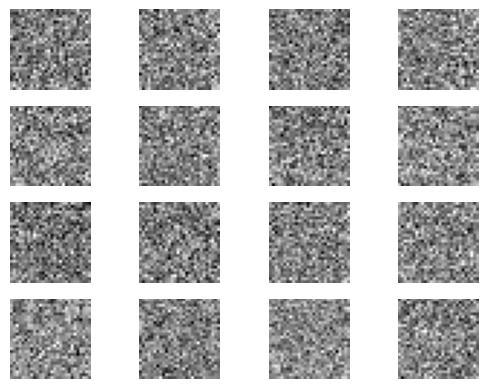

2/2 [==============================] - 0s 16ms/step
1000 [D loss: 0.03956851572729647, acc.: 99.21875] [G loss: 9.28537368774414]
1/1 [==============================] - 0s 30ms/step


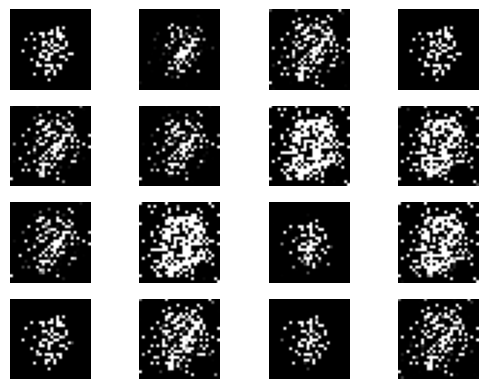

2/2 [==============================] - 0s 14ms/step


KeyboardInterrupt: 

In [ ]:
def train_gan(gan, generator, discriminator, epochs, batch_size, sample_interval):
    (X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, valid)

        if epoch % sample_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}] [G loss: {g_loss}]")
            sample_images(generator, epoch)

def sample_images(generator, epoch, grid_rows=4, grid_cols=4):
    noise = np.random.normal(0, 1, (grid_rows * grid_cols, 100))
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(grid_rows, grid_cols)
    cnt = 0
    for i in range(grid_rows):
        for j in range(grid_cols):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

epochs = 10000
batch_size = 64
sample_interval = 1000
train_gan(gan, generator, discriminator, epochs, batch_size, sample_interval)